# This notebook will run stats and averaging of theta dominant frequency

### It depends on the data structure generated by 'Compute_dominant_frequency.ipynb', located in ''../Results/log_welch.npy''

In [3]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter
from scipy import stats 

## time_frequency
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

# Load study related info

In [4]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed']
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

# Load theta dominant frequency data

In [5]:
# log_welch = np.load('../Results/log_welch.npy',encoding='latin1')
log_welch = np.load('../Results/log_welch_0_1500_4_28_15_2.npy',encoding='latin1')

# The big model : 
### dataframe with all subjects data

In [6]:
log_wel_all = []

for ss in range(len(log_welch)):
    
    for tt in range(len(log_welch[ss])):
        
        
        cs = log_welch[ss][tt][3]
        csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))
        log_wel_all.append( [ ss, log_welch[ss][tt][1] , log_welch[ss][tt][2] , cs , csw, log_welch[ss][tt][4] ] )
        
        
log_wel_all = np.array(log_wel_all)

In [8]:
log_wel_all = pd.DataFrame(log_wel_all, columns=['sub','density','speed','cuesec', 'cuesec_w', 'freq'] )

In [385]:
log_wel_all.to_pickle('dom_freq_df')

              sum_sq     df         F    PR(>F)
freq        1.235832    1.0  1.853412  0.173767
Residual  538.764168  808.0       NaN       NaN
              sum_sq     df         F    PR(>F)
freq        2.502742    1.0  3.762281  0.052769
Residual  537.497258  808.0       NaN       NaN


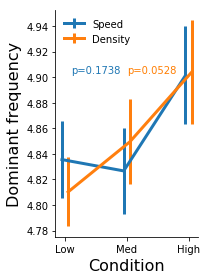

In [409]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)


mmd = log_wel_all.groupby(['density']).mean()['freq']
mms = log_wel_all.groupby(['speed']).mean()['freq']

ssd = log_wel_all.groupby(['density']).sem()['freq']
sss = log_wel_all.groupby(['speed']).sem()['freq']

plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)
plt.legend( frameon=False, loc='upper left')

plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)

plt.xticks(range(3), ['Low','Med','High'])




cw_lm=ols('speed ~ freq', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
pval_speed_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['freq'],4))

cw_lm=ols('density ~ freq', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
pval_density_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['freq'],4))


new_blue   = '#1f77b4'
new_orange = '#ff7f03'

ym = plt.ylim()[1]*0.99
plt.text( 0.1, ym, pval_speed_str,  fontdict=dict(color=new_blue) )
plt.text( 0.1+.9, ym, pval_density_str,  fontdict=dict(color=new_orange) )





plt.tight_layout()

# plt.savefig('../Figures/theta_dominant_freq_both.pdf')

plt.savefig('../Figures/domfreq_condition.pdf', bbox_inches='tight')

Pearson:  (0.0914395082034596, 0.009218260280762688)
             sum_sq     df         F    PR(>F)
freq        5.63117    1.0  6.369238  0.011802
Residual  714.36883  808.0       NaN       NaN


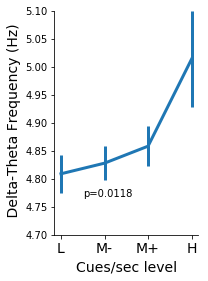

In [410]:
mmcs = log_wel_all.groupby(['cuesec_w']).mean()['freq']
sscs = log_wel_all.groupby(['cuesec_w']).sem()['freq']


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)


# ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
ax.errorbar( range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )
# ax.bar( range(mmcs.size), mmcs, yerr=sscs, color='grey' )

# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('Cues/sec level', fontsize=14)

plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )

plt.tight_layout()


plt.ylim(4.7,5.1)

print( 'Pearson: ',  stats.pearsonr(log_wel_all.cuesec, log_wel_all.freq ))

cw_lm=ols('cuesec_w ~ freq', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))


ym = sum(plt.ylim())/2.055
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['freq'],4))
plt.text( 0.5, ym, pval_str )



# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')
plt.savefig('../Figures/domfreq_cuesec.pdf', bbox_inches='tight')

In [366]:
cw_lm=ols('freq ~ density+speed', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=3))

                sum_sq     df             F    PR(>F)
Intercept  4616.883041    1.0  14717.528555  0.000000
density       1.181482    1.0      3.766284  0.052644
speed         0.583405    1.0      1.859758  0.173033
Residual    253.155589  807.0           NaN       NaN


In [367]:
real_control = 'control'


all_control = []


for iix in range(100):

    save_freq_in_cs =[]
    for cs in log_wel_all.cuesec.unique():
        idx = np.where( log_wel_all.cuesec==cs )[0]
        if real_control == 'control':
            idx = np.random.randint( 0, log_wel_all.shape[0], idx.size  )
        save_freq_in_cs.append( log_wel_all.freq[idx] )





    if real_control == 'real':
        rmm,rss = [],[]
        for ii in range(len(save_freq_in_cs)):    
            rmm.append(np.mean(save_freq_in_cs[ii]))
            rss.append(stats.sem(save_freq_in_cs[ii]))

    if real_control == 'control':
        control_mm,control_ss = [],[]
        for ii in range(len(save_freq_in_cs)):    
            control_mm.append(np.mean(save_freq_in_cs[ii]))
            control_ss.append(stats.sem(save_freq_in_cs[ii]))

        all_control.append(control_mm)
        
all_control = np.array(all_control)




control_m = np.mean(all_control,axis=0)
control_s = stats.sem(all_control,axis=0)


Pearson:  (0.0914395082034596, 0.009218260280762688)
               sum_sq     df         F    PR(>F)
freq        77.593999    1.0  6.812799  0.009218
Residual  9202.670861  808.0       NaN       NaN


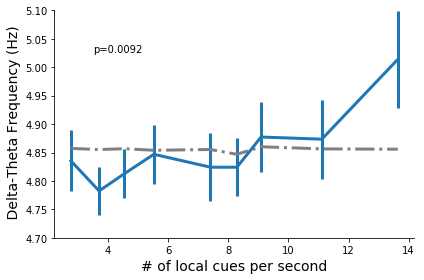

In [411]:
mmcs = log_wel_all.groupby(['cuesec']).mean()['freq']
sscs = log_wel_all.groupby(['cuesec']).sem()['freq']


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)



plt.plot(uni, control_m, linestyle='-.', color='grey', linewidth=3 )
ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3  )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('# of local cues per second', fontsize=14)



# plt.title('Navigation')

plt.ylim(4.7,5.1)

plt.tight_layout()


print( 'Pearson: ',  stats.pearsonr(log_wel_all.cuesec, log_wel_all.freq ))

cw_lm=ols('cuesec ~ freq', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))



ym = sum(plt.ylim())/1.95
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['freq'],4))
plt.text( 3.5, ym, pval_str )



# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')
plt.savefig('../Figures/domfreq_cuesec_more.pdf', bbox_inches='tight')

# Agregate data by subject/condition

In [11]:
log_wel_all_np = log_wel_all.to_numpy()
log_wel_all.head()

,sub,density,speed,cuesec,cuesec_w,freq
0,0.0,0.0,0.0,2.762431,0.0,4.778667
1,0.0,0.0,1.0,3.703704,0.0,4.437333
2,0.0,0.0,2.0,4.545455,1.0,4.778667
3,0.0,1.0,0.0,5.524862,1.0,4.778667
4,0.0,1.0,1.0,7.407407,1.0,4.778667


(0.19714110636738222, 0.35583036902546616)
(0.17492714467879844, 0.4136149741561441)


([<matplotlib.axis.XTick at 0x116133630>,
 <a list of 3 Text xticklabel objects>)

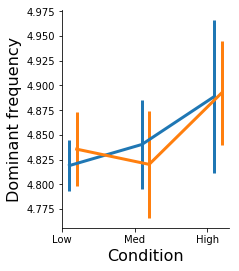

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)



for cond in [1,2]:
    tmp = []
    for sub in range(8):
        tmp_tmp = [] 
        for cuesec in range(3):
            idx = np.where(  np.logical_and( log_wel_all_np[:,0]==sub, log_wel_all_np[:,cond]==cuesec )   )
            mmmm1 = np.mean( log_wel_all_np[idx,5] )

            tmp_tmp.append( mmmm1 )
        tmp.append(tmp_tmp)
    tmp = np.array(tmp)


    plt.errorbar( np.arange(tmp.shape[1])+0.1*cond, np.mean(tmp,axis=0), stats.sem(tmp,axis=0), linewidth=3 )
    print( stats.pearsonr(np.tile(np.arange(3),8) , tmp.flatten() ) )
    
    
fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
plt.xticks(range(3), ['Low','Med','High'])

(0.3066024509789043, 0.08786230324770096)


Text(0, 0.5, 'Dominant frequency')

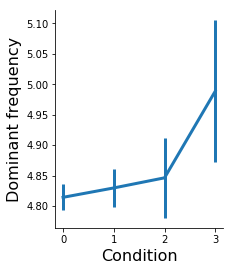

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)


tmp = []
for sub in range(8):
    tmp_tmp = [] 
    for cuesec in range(4):
        idx = np.where(  np.logical_and( log_wel_all_np[:,0]==sub, log_wel_all_np[:,4]==cuesec )   )
        mmmm1 = np.mean( log_wel_all_np[idx,5] )

        tmp_tmp.append( mmmm1 )
    tmp.append(tmp_tmp)
tmp = np.array(tmp)


plt.errorbar( np.arange(tmp.shape[1]), np.mean(tmp,axis=0), stats.sem(tmp,axis=0), linewidth=3 )
print( stats.pearsonr(np.tile(np.arange(4),8) , tmp.flatten() ) )

    
fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
# plt.xticks(range(3), ['Low','Med','High'])

(0.1790041784488665, 0.13245305858282277)


Text(0, 0.5, 'Dominant frequency')

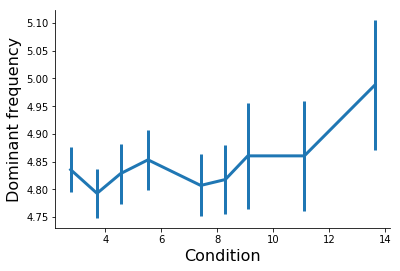

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(6)


tmp = []
for sub in range(8):
    tmp_tmp = [] 
    for cuesec in np.sort(np.unique(log_wel_all_np[:,3])):
        idx = np.where(  np.logical_and( log_wel_all_np[:,0]==sub, log_wel_all_np[:,3]==cuesec )   )
        mmmm1 = np.mean( log_wel_all_np[idx,5] )

        tmp_tmp.append( mmmm1 )
    tmp.append(tmp_tmp)
tmp = np.array(tmp)


plt.errorbar( uni, np.average(tmp,axis=0), stats.sem(tmp,axis=0), linewidth=3 )
print( stats.pearsonr(np.tile(np.arange(9),8) , tmp.flatten() ) )

    
fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
# plt.xticks(range(3), ['Low','Med','High'])